# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [35]:
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [37]:
X_train = np.loadtxt("C:/Users/mrbor/PycharmProjects/ML_MAI/hw3/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("C:/Users/mrbor/PycharmProjects/ML_MAI/hw3/human+activity+recognition+using+smartphones/UCI HAR Dataset//UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("C:/Users/mrbor/PycharmProjects/ML_MAI/hw3/human+activity+recognition+using+smartphones/UCI HAR Dataset//UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("C:/Users/mrbor/PycharmProjects/ML_MAI/hw3/human+activity+recognition+using+smartphones/UCI HAR Dataset//UCI HAR Dataset/test/y_test.txt").astype(int)

In [38]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [39]:
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

print(f"Объединённая выборка X: {X.shape}")
print(f"Объединённые метки y: {y.shape}")

Объединённая выборка X: (10299, 561)
Объединённые метки y: (10299,)


Определим число уникальных значений меток целевого класса.

In [40]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [41]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Проверка: среднее близко к 0, стандартное отклонение близко к 1
print(f"Среднее: {X_scaled.mean(axis=0)[:5]}")  # первые 5 признаков
print(f"Стандартное отклонение: {X_scaled.std(axis=0)[:5]}")

Среднее: [ 5.52841263e-15 -1.38651383e-15 -5.28337448e-15 -2.21336365e-15
  4.63827227e-16]
Стандартное отклонение: [1. 1. 1. 1. 1.]


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [43]:
# Определяем количество компонент для 90% дисперсии
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

n_pca_components = pca.n_components_
print(f"Число компонент для 90% дисперсии: {n_pca_components}")
print(f"Объяснённая дисперсия: {pca.explained_variance_ratio_.sum():.4f}")

Число компонент для 90% дисперсии: 65
Объяснённая дисперсия: 0.9005


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [44]:
print(f"Число компонент для 90% дисперсии: {pca.n_components_}")

Число компонент для 90% дисперсии: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [45]:
first_pc_variance = pca.explained_variance_ratio_[0] * 100
print(f"Дисперсия первой ПК: {first_pc_variance:.1f}%")
print(f"Округлено: {round(first_pc_variance)}%")

Дисперсия первой ПК: 50.7%
Округлено: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

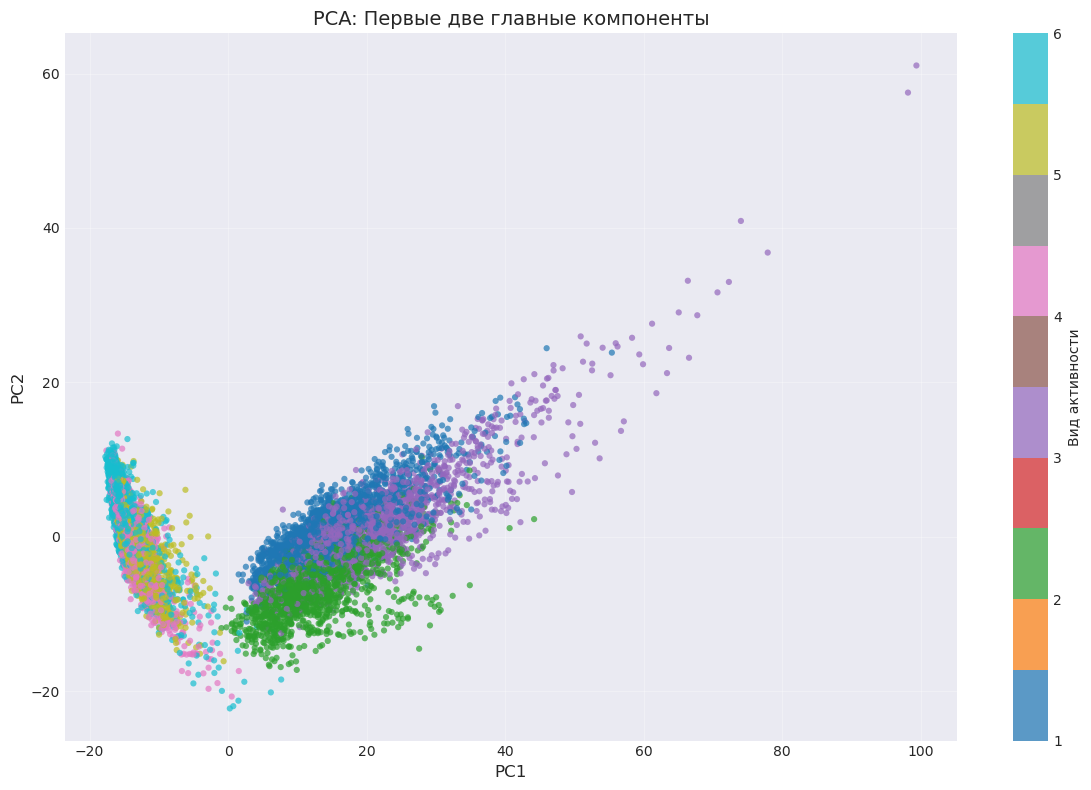

Уникальные метки: [1 2 3 4 5 6]


In [46]:
# Визуализация исходных данных по видам активности
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, 
                      cmap='tab10', alpha=0.7, edgecolors='none')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('PCA: Первые две главные компоненты', fontsize=14)
plt.colorbar(scatter, label='Вид активности')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Уникальные метки: {np.unique(y)}")

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [47]:
# Кластеризация методом KMeans с параметрами задания
kmeans = KMeans(n_clusters=n_classes, 
                n_init=100, 
                random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

print(f"Найденные центры кластеров: {kmeans.cluster_centers_.shape}")
print(f"Inertia: {kmeans.inertia_:.2f}")

Найденные центры кластеров: (6, 65)
Inertia: 2003454.90


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

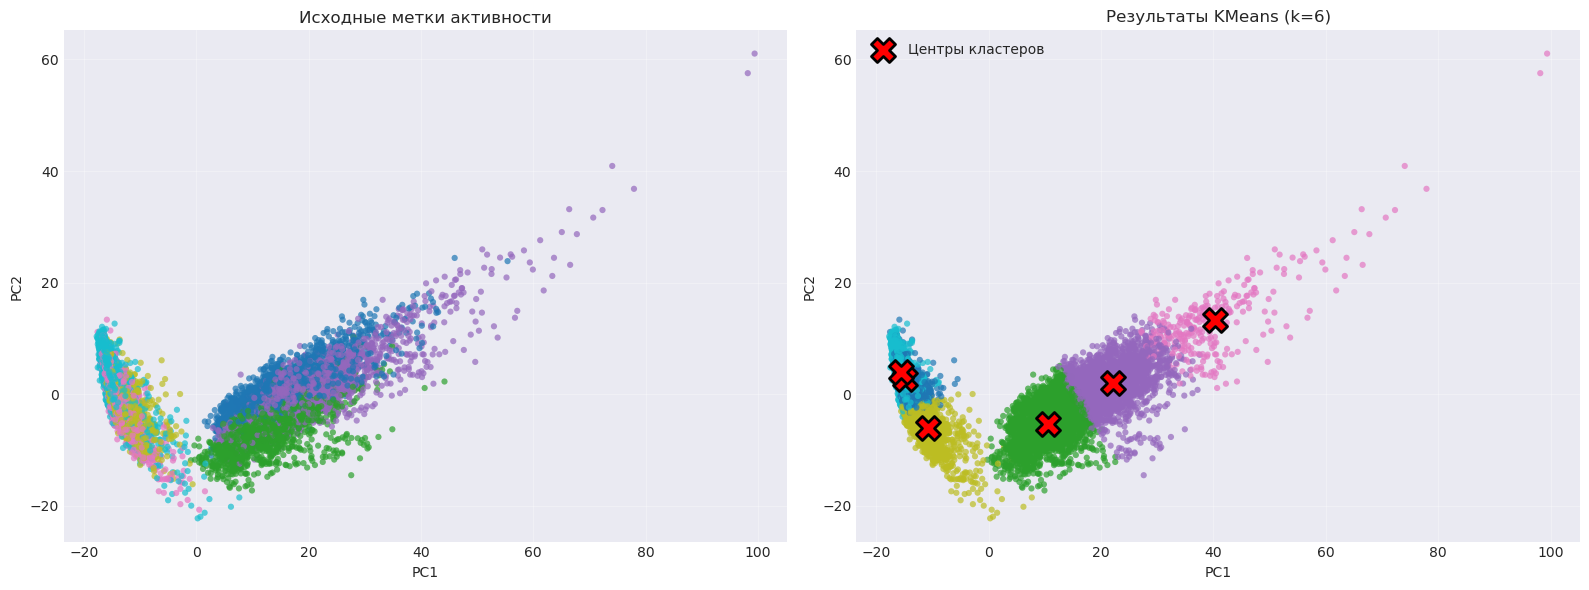

In [48]:
# Построение графика с метками кластеров
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: исходные метки классов
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20,  # <-- axes[0]
                cmap='tab10', alpha=0.7, edgecolors='none')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Исходные метки активности')
axes[0].grid(True, alpha=0.3)

# График 2: полученные кластеры
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  # <-- axes[1]
                cmap='tab10', alpha=0.7, edgecolors='none')
axes[1].scatter(kmeans.cluster_centers_[:, 0], 
               kmeans.cluster_centers_[:, 1],
               c='red', marker='X', s=300, edgecolors='black', linewidths=2,
               label='Центры кластеров')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Результаты KMeans (k=6)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [49]:
# Кроссстабуляция с информативными индексами
activity_names = ['ходьба', 'подъём вверх', 'спуск вниз', 
                  'сидение', 'стояние', 'лежание']
cluster_names = [f'кластер_{i}' for i in range(1, 7)]

tab = pd.crosstab(y, cluster_labels)
tab.index = activity_names
tab.columns = cluster_names
print("\nМатрица соответствия (исходные классы × кластеры):")
print(tab)

# Добавляем маржи для анализа
tab_with_margins = pd.crosstab(y, cluster_labels, margins=True)
tab_with_margins.index = activity_names + ['Всего']
tab_with_margins.columns = cluster_names + ['Всего']
print("\nС маржами:")
print(tab_with_margins)


Матрица соответствия (исходные классы × кластеры):
              кластер_1  кластер_2  кластер_3  кластер_4  кластер_5  кластер_6
ходьба                0        903        741         78          0          0
подъём вверх          0       1241        296          5          2          0
спуск вниз            0        320        890        196          0          0
сидение            1235          1          0          0        450         91
стояние            1344          0          0          0        562          0
лежание              52          5          0          0        329       1558

С маржами:
              кластер_1  кластер_2  кластер_3  кластер_4  кластер_5  \
ходьба                0        903        741         78          0   
подъём вверх          0       1241        296          5          2   
спуск вниз            0        320        890        196          0   
сидение            1235          1          0          0        450   
стояние            1344     

In [50]:
# Максимальная доля объектов класса в одном кластере
max_fractions = []
for class_id in np.unique(y):
    class_mask = (y == class_id)
    class_counts = np.bincount(cluster_labels[class_mask], 
                                minlength=n_classes)
    max_fraction = class_counts.max() / class_mask.sum()
    max_fractions.append(max_fraction)
    print(f"Активность {class_id} ({activity_names[class_id-1]}): "
          f"макс. доля = {max_fraction:.3f}")

best_separated_idx = np.argmax(max_fractions)
best_separated = activity_names[best_separated_idx]
print(f"\nЛучше всего отделилась: {best_separated}")

Активность 1 (ходьба): макс. доля = 0.524
Активность 2 (подъём вверх): макс. доля = 0.804
Активность 3 (спуск вниз): макс. доля = 0.633
Активность 4 (сидение): макс. доля = 0.695
Активность 5 (стояние): макс. доля = 0.705
Активность 6 (лежание): макс. доля = 0.801

Лучше всего отделилась: подъём вверх


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

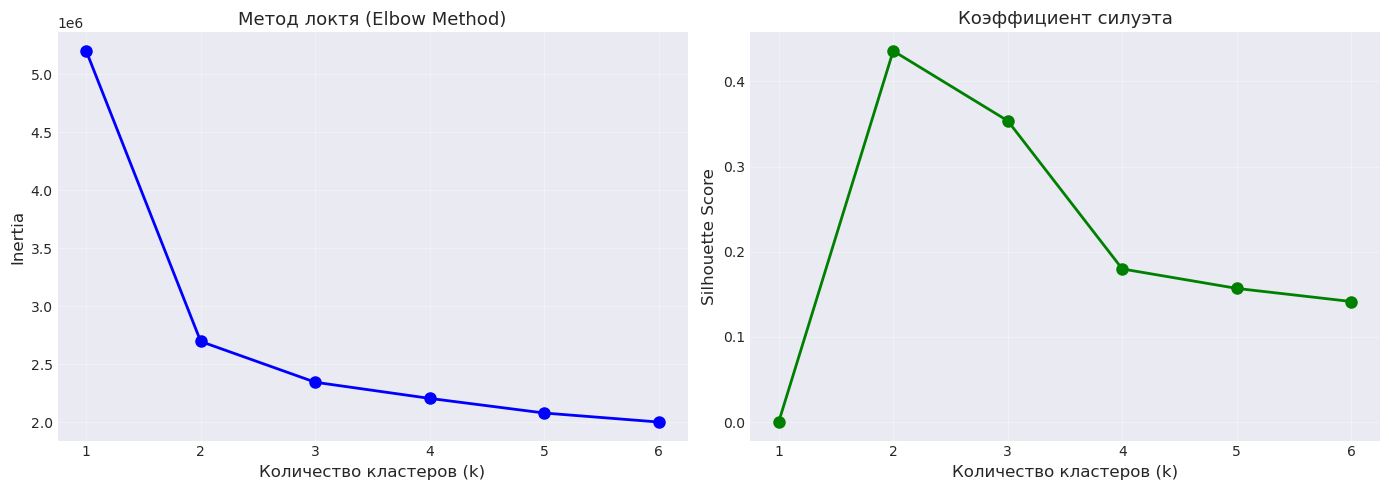

Inertia по k:
  k=1: 5202758
  k=2: 2697927
  k=3: 2346425
  k=4: 2207132
  k=5: 2080985
  k=6: 2003455


In [51]:
# Метод локтя: пересчет KMeans для разного числа кластеров
inertia_values = []
silhouette_scores = []
K_range = range(1, n_classes + 1)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_pca)
    inertia_values.append(km.inertia_)
    
    if k > 1:
        silhouette_scores.append(metrics.silhouette_score(X_pca, labels))
    else:
        silhouette_scores.append(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Inertia
axes[0].plot(K_range, inertia_values, 'bo-', linewidth=2, markersize=8)  # <-- axes[0]
axes[0].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Метод локтя (Elbow Method)', fontsize=13)
axes[0].grid(True, alpha=0.3)

# График 2: Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)  # <-- axes[1]
axes[1].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Коэффициент силуэта', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Inertia по k:")
for k, inert in zip(K_range, inertia_values):
    print(f"  k={k}: {inert:.0f}")


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

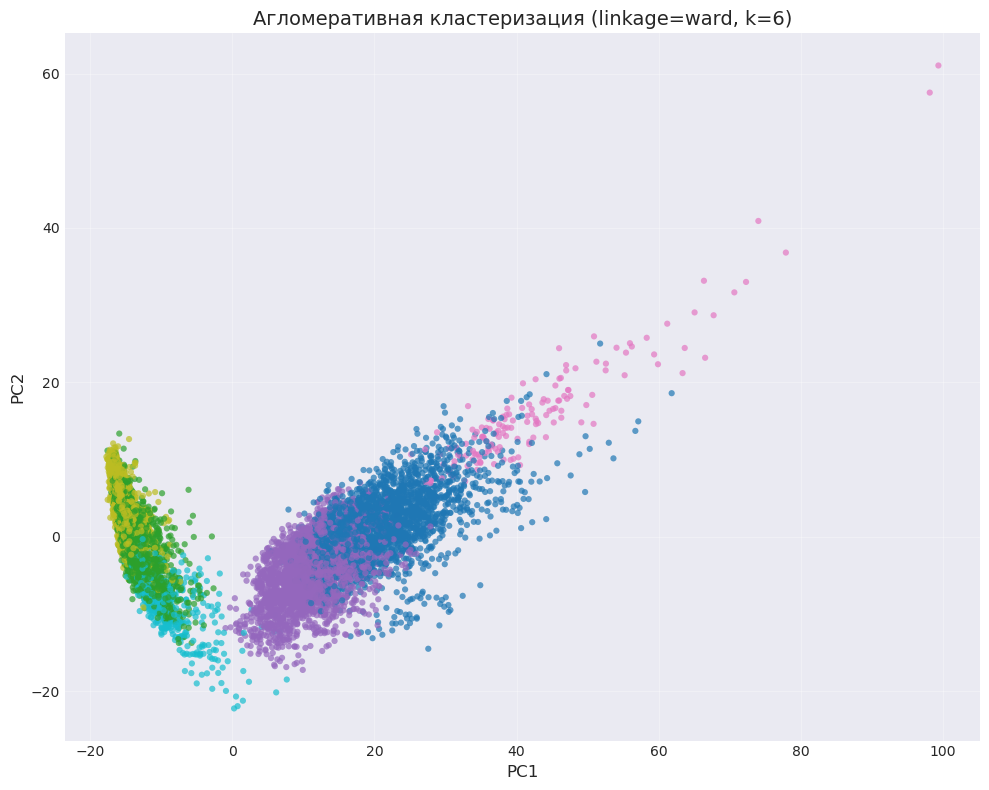

In [66]:
agg_clustering = AgglomerativeClustering(
    n_clusters=n_classes,
    linkage='ward'
)
agg_labels = agg_clustering.fit_predict(X_pca)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, s=20, 
            cmap='tab10', alpha=0.7, edgecolors='none')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('Агломеративная кластеризация (linkage=ward, k=6)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [53]:
# ARI для KMeans
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
print(f"Adjusted Rand Index (KMeans): {ari_kmeans:.4f}")

# ARI для Agglomerative Clustering
ari_agg = metrics.adjusted_rand_score(y, agg_labels)
print(f"Adjusted Rand Index (Agglomerative): {ari_agg:.4f}")

print(f"\nКакой лучше? ", end="")
if ari_kmeans > ari_agg:
    print(f"KMeans (разница: {ari_kmeans - ari_agg:.4f})")
else:
    print(f"Agglomerative (разница: {ari_agg - ari_kmeans:.4f})")

print(f"\nНормализованная взаимная информация (NMI):")
print(f"  KMeans: {metrics.normalized_mutual_info_score(y, cluster_labels):.4f}")
print(f"  Agglomerative: {metrics.normalized_mutual_info_score(y, agg_labels):.4f}")

Adjusted Rand Index (KMeans): 0.4198
Adjusted Rand Index (Agglomerative): 0.4936

Какой лучше? Agglomerative (разница: 0.0738)

Нормализованная взаимная информация (NMI):
  KMeans: 0.5602
  Agglomerative: 0.6218


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

In [54]:
# Расширенный анализ качества кластеризации
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ КЛАСТЕРИЗАЦИИ")

metrics_dict = {
    'Метрика': ['Adjusted Rand Index', 
                'Normalized Mutual Info',
                'Homogeneity Score',
                'Completeness Score',
                'V-measure'],
    'KMeans': [
        metrics.adjusted_rand_score(y, cluster_labels),
        metrics.normalized_mutual_info_score(y, cluster_labels),
        metrics.homogeneity_score(y, cluster_labels),
        metrics.completeness_score(y, cluster_labels),
        metrics.v_measure_score(y, cluster_labels)
    ],
    'Agglomerative': [
        metrics.adjusted_rand_score(y, agg_labels),
        metrics.normalized_mutual_info_score(y, agg_labels),
        metrics.homogeneity_score(y, agg_labels),
        metrics.completeness_score(y, agg_labels),
        metrics.v_measure_score(y, agg_labels)
    ]
}

comparison_df = pd.DataFrame(metrics_dict)
print(comparison_df.to_string(index=False))


СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ КЛАСТЕРИЗАЦИИ
               Метрика   KMeans  Agglomerative
   Adjusted Rand Index 0.419807       0.493628
Normalized Mutual Info 0.560230       0.621786
     Homogeneity Score 0.540758       0.577907
    Completeness Score 0.581158       0.672874
             V-measure 0.560230       0.621786


-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [55]:
scaler_classification = StandardScaler()
X_train_scaled = scaler_classification.fit_transform(X_train)
X_test_scaled = scaler_classification.transform(X_test)

print(f'Масштабированные выборки для классификации:')
print(f'  X_train_scaled: {X_train_scaled.shape}')
print(f'  X_test_scaled: {X_test_scaled.shape}')

Масштабированные выборки для классификации:
  X_train_scaled: (7352, 561)
  X_test_scaled: (2947, 561)


In [56]:
from sklearn.model_selection import GridSearchCV

svc = LinearSVC(random_state=RANDOM_STATE, max_iter=2000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(
    svc, 
    svc_params, 
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print('Обучение GridSearchCV (БЕЗ PCA)...')
grid_search.fit(X_train_scaled, y_train)

best_svc = grid_search.best_estimator_
best_c = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f'\nРезультаты GridSearchCV (БЕЗ PCA):')
print(f'Лучший параметр C: {best_c}')
print(f'Лучший CV score: {best_score:.4f}')

Обучение GridSearchCV (БЕЗ PCA)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Результаты GridSearchCV (БЕЗ PCA):
Лучший параметр C: 0.1
Лучший CV score: 0.9380


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [57]:
y_predicted = best_svc.predict(X_test_scaled)

test_accuracy = metrics.accuracy_score(y_test, y_predicted)
print(f'Точность на тестовой выборке: {test_accuracy:.4f}')

Точность на тестовой выборке: 0.9620


In [58]:
activity_names = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
                  'сидение', 'стояние', 'лежание']

tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = activity_names + ['все']
tab.columns = activity_names + ['все']

print('\nМатрица соответствия (истинные × предсказанные):')
print(tab)


Матрица соответствия (истинные × предсказанные):
                          ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                         2                  0   
подъем вверх по лестнице      12                       459                  0   
спуск по лестнице              2                         4                413   
сидение                        0                         4                  0   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          508                       469                413   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   496  
подъем вверх по лестнице        0        0        0   471  
спуск по лестнице               1        0        0   420  
сидение                       426       61        0   491  
с

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

In [59]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_predicted, 
    labels=[1, 2, 3, 4, 5, 6],
    zero_division=0
)

print('\nМетрики по классам:')
print(f'{"Активность":<30} {"Precision":<12} {"Recall":<12} {"Support"}')
print('-' * 70)

for i, name in enumerate(activity_names):
    print(f'{name:<30} {precision[i]:<12.3f} {recall[i]:<12.3f} {support[i]}')

# Находим худшие классы
worst_precision_idx = np.argmin(precision)
worst_recall_idx = np.argmin(recall)

print(f'\nХуже всего по полноте: {activity_names[worst_precision_idx]}')
print(f'Хуже всего по точности: {activity_names[worst_recall_idx]}')


Метрики по классам:
Активность                     Precision    Recall       Support
----------------------------------------------------------------------
ходьба                         0.972        0.996        496
подъем вверх по лестнице       0.979        0.975        471
спуск по лестнице              1.000        0.983        420
сидение                        0.964        0.868        491
стояние                        0.878        0.972        532
лежание                        1.000        0.980        537

Хуже всего по полноте: стояние
Хуже всего по точности: сидение


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [60]:
pca_classification = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_classification.fit_transform(X_train_scaled)
X_test_pca = pca_classification.transform(X_test_scaled)

print(f'PCA для классификации:')
print(f'  Число компонент: {pca_classification.n_components_}')
print(f'  Объяснённая дисперсия: {pca_classification.explained_variance_ratio_.sum():.4f}')
print(f'  X_train_pca: {X_train_pca.shape}')
print(f'  X_test_pca: {X_test_pca.shape}')

PCA для классификации:
  Число компонент: 63
  Объяснённая дисперсия: 0.9005
  X_train_pca: (7352, 63)
  X_test_pca: (2947, 63)


In [61]:
# 6. GridSearchCV С PCA
svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=2000)
svc_params_pca = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search_pca = GridSearchCV(
    svc_pca,
    svc_params_pca,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print('Обучение GridSearchCV (С PCA)...')
grid_search_pca.fit(X_train_pca, y_train)

best_svc_pca = grid_search_pca.best_estimator_
best_c_pca = grid_search_pca.best_params_['C']
best_score_pca = grid_search_pca.best_score_

print(f'\nРезультаты GridSearchCV (С PCA):')
print(f'Лучший параметр C: {best_c_pca}')
print(f'Лучший CV score: {best_score_pca:.4f}')

Обучение GridSearchCV (С PCA)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Результаты GridSearchCV (С PCA):
Лучший параметр C: 0.1
Лучший CV score: 0.8984


In [62]:
diff_absolute = abs(best_score - best_score_pca)
diff_percent = diff_absolute * 100

print(f'СРАВНЕНИЕ КАЧЕСТВА (CV score):')
print(f'БЕЗ PCA (561 признак):  {best_score:.4f}')
print(f'С PCA ({pca_classification.n_components_} компонент):      {best_score_pca:.4f}')
print(f'Разница:                {diff_percent:.1f}%')


if diff_percent < 1:
    answer_q9 = 'Качество одинаковое'
elif diff_percent < 3:
    answer_q9 = '2%'
elif diff_percent < 6:
    answer_q9 = '4%'
elif diff_percent < 15:
    answer_q9 = '10%'
else:
    answer_q9 = '20%'

СРАВНЕНИЕ КАЧЕСТВА (CV score):
БЕЗ PCA (561 признак):  0.9380
С PCA (63 компонент):      0.8984
Разница:                4.0%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

In [63]:
print('ВОПРОС 10: Анализ утверждений')

print('\n1. "PCA позволил уменьшить время, но качество пострадало >10%"')
if diff_percent > 10:
    print(f'   ВЕРНО (разница {diff_percent:.1f}%)')
else:
    print(f'   НЕВЕРНО (разница всего {diff_percent:.1f}%)')

print('\n2. "PCA хорош для визуализации, но tSNE лучше. PCA имеет меньшую сложность"')
print('   ВЕРНО (это математически корректное утверждение)')

print('\n3. "PCA строит линейные комбинации, они могут плохо интерпретироваться"')
print('   ВЕРНО (это известная проблема PCA)')

ВОПРОС 10: Анализ утверждений

1. "PCA позволил уменьшить время, но качество пострадало >10%"
   НЕВЕРНО (разница всего 4.0%)

2. "PCA хорош для визуализации, но tSNE лучше. PCA имеет меньшую сложность"
   ВЕРНО (это математически корректное утверждение)

3. "PCA строит линейные комбинации, они могут плохо интерпретироваться"
   ВЕРНО (это известная проблема PCA)


**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

Применяем t-SNE
После t-SNE: (5000, 2)


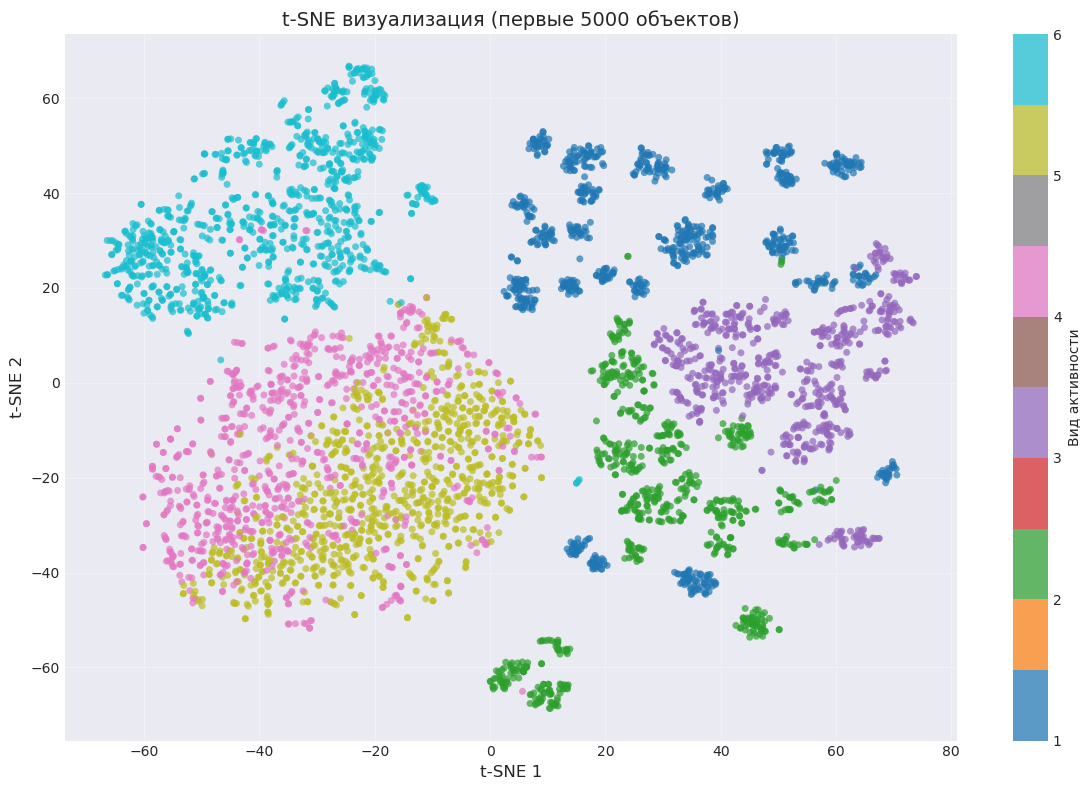

In [64]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# t-SNE для понижения размерности (альтернатива PCA)
print('Применяем t-SNE')
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled[:5000])  # берём подмножество для скорости
y_tsne = y[:5000]

print(f'После t-SNE: {X_tsne.shape}')

# Визуализация t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, s=25, 
                     cmap='tab10', alpha=0.7, edgecolors='none')
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('t-SNE визуализация (первые 5000 объектов)', fontsize=14)
plt.colorbar(scatter, label='Вид активности')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


DBSCAN результаты:
  Найдено кластеров: 68
  Шумовых точек: 296
  Уникальные метки: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


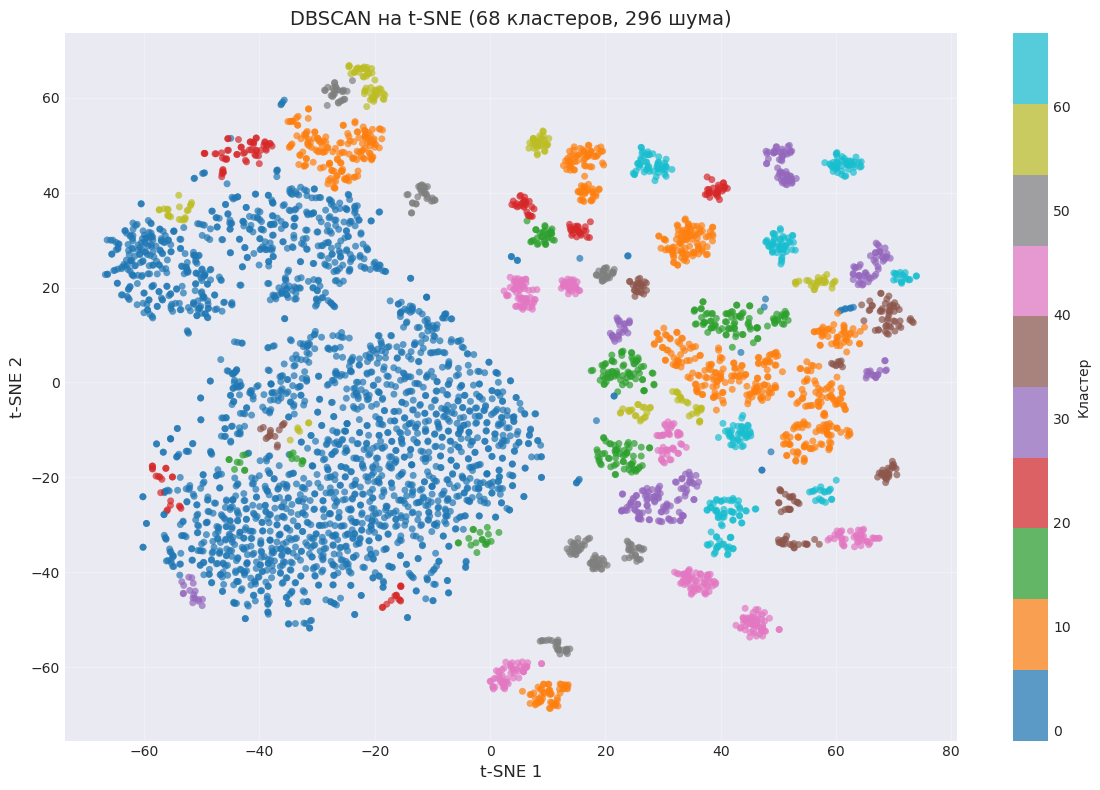


Adjusted Rand Index (DBSCAN): 0.3222


In [65]:
# DBSCAN кластеризация на t-SNE данных
dbscan = DBSCAN(eps=2.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_tsne)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'\nDBSCAN результаты:')
print(f'  Найдено кластеров: {n_clusters_dbscan}')
print(f'  Шумовых точек: {n_noise}')
print(f'  Уникальные метки: {np.unique(dbscan_labels)}')

# Визуализация DBSCAN
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=25,
                     cmap='tab10', alpha=0.7, edgecolors='none')
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title(f'DBSCAN на t-SNE ({n_clusters_dbscan} кластеров, {n_noise} шума)', fontsize=14)
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ARI для DBSCAN
ari_dbscan = metrics.adjusted_rand_score(y_tsne, dbscan_labels)
print(f'\nAdjusted Rand Index (DBSCAN): {ari_dbscan:.4f}')